# Sustainable AI – Energy Usage Prediction

This notebook trains and evaluates a machine learning model to **predict energy usage (kWh)** for LLM-style workloads
using synthetic configuration data. It also prepares a helper function that can be used by the main application
(for example, a Streamlit UI) to estimate energy for user-provided configurations.

**Data source:** `energy_training_data.csv` (synthetic).

## 1. Setup and Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import os
import joblib
# Change working directory 
os.chdir('C:\Conestoga Projects\CSCN8010_MLF\Sustainable_AI\data')


plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = True

print("Libraries imported.")

Libraries imported.


## 2. Load Synthetic Energy Dataset

In [4]:
# Load the synthetic dataset
df = pd.read_csv("energy_training_data.csv")
print("Data shape:", df.shape)
df.head()

Data shape: (1000, 7)


,num_layers,training_hours,flops_per_hour,prompt_tokens,gpu_power_watts,batch_size,energy_kwh
0,21,3.036058,1.180361e+08,189,310.323046,77,2.857136
1,25,45.526522,4.491940e+07,270,277.679971,33,5.414321
2,10,30.477541,1.309254e+08,175,133.931910,145,5.114819
3,61,29.960245,1.338420e+08,511,305.704786,188,6.623944
4,32,18.246479,5.337145e+07,422,146.572406,38,4.476142


### 2.1 Quick Data Check

In [5]:
display(df.describe(include='all'))
df.isna().sum()

,num_layers,training_hours,flops_per_hour,prompt_tokens,gpu_power_watts,batch_size,energy_kwh
count,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000
mean,37.489000,23.351605,9.854566e+07,302.014000,236.716061,131.106000,4.530175
std,19.569436,13.638029,5.699511e+07,173.173193,66.083092,74.810128,1.471780
min,4.000000,0.574009,5.441136e+05,5.000000,120.543853,1.000000,0.464810
25%,21.000000,11.515829,4.766908e+07,151.000000,177.657638,65.000000,3.548171
50%,37.000000,22.892441,9.853768e+07,300.500000,237.064110,129.500000,4.423887
75%,54.000000,35.132883,1.483205e+08,458.000000,293.953454,198.000000,5.527277
max,72.000000,47.927784,1.993595e+08,599.000000,348.396033,255.000000,8.810167


num_layers         0
training_hours     0
flops_per_hour     0
prompt_tokens      0
gpu_power_watts    0
batch_size         0
energy_kwh         0
dtype: int64

## 3. Feature Definition and Train/Test Split

In [6]:
# Define feature columns and target column
FEATURES = [
    "num_layers",
    "training_hours",
    "flops_per_hour",
    "prompt_tokens",
    "gpu_power_watts",
    "batch_size",
]
TARGET = "energy_kwh"

X = df[FEATURES].values
y = df[TARGET].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2825
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

Train shape: (800, 6)
Test shape : (200, 6)


## 4. Baseline Models – Linear Regression vs Random Forest

In [7]:
def evaluate_regression_model(model, X_train, y_train, X_test, y_test, name="model"):
    """Fit model and print MAE, RMSE, R² on the test set."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)

    print(f"[{name}]")
    print(f"  MAE : {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²  : {r2:.4f}")

    return {"mae": mae, "rmse": rmse, "r2": r2}, y_pred

# Define models
lin_reg = LinearRegression()
rf_reg = RandomForestRegressor(
    n_estimators=200,
    random_state=2825,
    n_jobs=-1
)

# Evaluate
metrics_lin, y_pred_lin = evaluate_regression_model(
    lin_reg, X_train, y_train, X_test, y_test, name="LinearRegression"
)

metrics_rf, y_pred_rf = evaluate_regression_model(
    rf_reg, X_train, y_train, X_test, y_test, name="RandomForestRegressor"
)

[LinearRegression]
  MAE : 0.5606
  RMSE: 0.7054
  R²  : 0.7721
[RandomForestRegressor]
  MAE : 0.6373
  RMSE: 0.8102
  R²  : 0.6994


### 4.1 Model Selection and Actual vs Predicted Plot

Selected best model: LinearRegression


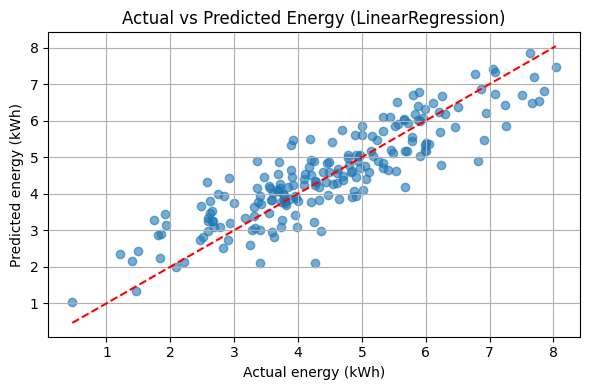

In [8]:
# Select the better model based on RMSE (you can change the criterion if desired)
if metrics_lin["rmse"] <= metrics_rf["rmse"]:
    best_model = lin_reg
    best_name = "LinearRegression"
    y_pred_best = y_pred_lin
else:
    best_model = rf_reg
    best_name = "RandomForestRegressor"
    y_pred_best = y_pred_rf

print("Selected best model:", best_name)

# Plot Actual vs Predicted on test set
plt.figure()
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.xlabel("Actual energy (kWh)")
plt.ylabel("Predicted energy (kWh)")
plt.title(f"Actual vs Predicted Energy ({best_name})")

min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")
plt.tight_layout()
plt.show()

## 5. Save Trained Energy Prediction Model

In [9]:
MODEL_DIR = "model"
ENERGY_MODEL_DIR = os.path.join(MODEL_DIR, "energy_predictor")
os.makedirs(ENERGY_MODEL_DIR, exist_ok=True)

energy_model_path = os.path.join(ENERGY_MODEL_DIR, "energy_predictor.pkl")
joblib.dump(best_model, energy_model_path)

print("Saved energy model to:", energy_model_path)

Saved energy model to: model\energy_predictor\energy_predictor.pkl


## 6. Helper Function `predict_energy`

In [10]:
def load_energy_model(path: str = energy_model_path):
    """Load the saved energy prediction model."""
    return joblib.load(path)

def predict_energy(
    num_layers: int,
    training_hours: float,
    flops_per_hour: float,
    prompt_tokens: int,
    gpu_power_watts: float,
    batch_size: int,
    model=None,
) -> float:
    """Predict energy consumption (kWh) for a given configuration."""
    if model is None:
        model = load_energy_model()

    X_input = np.array([[
        num_layers,
        training_hours,
        flops_per_hour,
        prompt_tokens,
        gpu_power_watts,
        batch_size,
    ]], dtype=float)

    return float(model.predict(X_input)[0])

# Sample test configuration
sample_energy = predict_energy(
    num_layers=24,
    training_hours=12.0,
    flops_per_hour=8e7,
    prompt_tokens=200,
    gpu_power_watts=250,
    batch_size=64,
)

print("Sample predicted energy (kWh):", sample_energy)

Sample predicted energy (kWh): 3.017116648744911
